In [5]:
import sys

# setting path
sys.path.append('../')
import TestFunctions as tf
#import TestFunctions as tf
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from importlib import reload
import random
import time
import matplotlib.animation as animation
import math

In [6]:
class Solution:
    def __init__(self, dimension, lower_bound, upper_bound):
        self.d = dimension
        self.lower = lower_bound # we will use the same bounds for all parameters
        self.upper = upper_bound
        self.params = np.zeros(self.d) #solution parameters
        self.f = np.inf # objective function evaluation

In [ ]:
def generatePopulation(solution : Solution, size):
    population = []
    for _ in range(0, size):
        new_solution = Solution(len(solution.params), solution.lower, solution.upper) # Generate solution
        for i in range(0, len(solution.params)): 
            new_solution.params[i] = random.uniform(solution.lower, solution.upper) # Generate its params
            #print(new_solution.params)
        population.append(new_solution)
    return population

# Evaluate entire population on function func
def evaluateAll(population, func):
    for solution in population:
        z = func(solution.params)
        solution.f = z
    return population

def pickBest(population):
    bestScore = 40000
    bestSolution = None
    for solution in population:
        if solution.f < bestScore:
            bestScore = solution.f
            bestSolution = solution
    return bestSolution

def generatePRTVector(solution, prt):
    vector = []
    for i in range(0, len(solution.params)):
        r = random.uniform(0,1)
        tmp = 0
        if r < prt:
            tmp = 1
        vector.append(tmp)
    return vector

def calculateNewPosition(current_solution : Solution, leader : Solution, func, step, prtVector, pathLength):
    t = step
    new_population = Solution(len(current_solution.params), current_solution.lower, current_solution.upper)
    while t < pathLength:
        for i in range(0, len(current_solution.params)):
            #print(type(prtVector))
            new_population.params[i] = current_solution.params[i] + (leader.params[i] - current_solution.params[i]) * t * prtVector[i]
        if func(new_population.params) < func(current_solution.params):
            current_solution.params = new_population.params.copy()
            current_solution.f = func(current_solution.params)
        t += step
    return current_solution

def SOMA(solution, func):
    for i in range(0,len(solution.params)):
        solution.params[i] = random.uniform(solution.lower, solution.upper) # Generate random coordinates for the first time

    # Parameters
    pop_size = 20          # Number of individuals in the population
    M_max = 100          # Maximum number of iterations
    step = 0.11                   # Step size for migration
    path_length = 3               # Path length, the extent each individual can move
    prt = 0.4

    #Initialize Population
    population = generatePopulation(solution=solution, size=pop_size)
    population = evaluateAll(population, func)
    leader = pickBest(population)
    progressTracker = []
    #Initial point
    progressTracker.append((leader.params.copy()[0], leader.params.copy()[1], leader.f))
    #Main Migration Loop
    for _ in range(0, M_max):
        # Identify the best individual in the population
        new_popuplation = list(np.copy(population)) # new generation
        leader = pickBest(population)
        if progressTracker[-1][0] != leader.params[0] and progressTracker[-1][1] != leader.params[1]:
            progressTracker.append((leader.params.copy()[0], leader.params.copy()[1], leader.f))
        # For each individual in the population (except the best one)
        for i in range(0, pop_size):
            if new_popuplation[i] == leader:
                continue  # Skip the best individual
            #Generate PRTVector
            prtVector = generatePRTVector(solution, prt)
            new_popuplation[i] = calculateNewPosition(new_popuplation[i], leader, func, step, prtVector, path_length)
            t = step
            
        population = new_popuplation

    # Step 4: Return best solution
    return progressTracker

In [8]:
def plot3DWithAnimation(xRangeMin, xRangeMax, yRangeMin, yRangeMax, func, params, gifName):
    x = np.linspace(xRangeMin, xRangeMax, 30)
    y = np.linspace(yRangeMin, yRangeMax, 30)
    #x = np.concatenate((x[x<0], [0], x[x>0]))#insert [0,0], doesnt work neither
    #y = np.concatenate((y[y<0], [0], y[y>0]))
    X, Y = np.meshgrid(x, y)
    Z = func((X, Y))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='magma', edgecolor='none', zorder=1, alpha=0.4)
    ax.set_title(func.__name__)
    ax.set_zlim(0, Z.max())
    scatter = ax.scatter([], [], [], color='red', s=100, zorder=4)  # Placeholder for the scatter plot
    # Function thats gonna be called by FuncAnimation at every interval
    def animate(i):
        x = [params[i][0]]  
        y = [params[i][1]]  
        z = [params[i][2]]
        scatter._offsets3d = (x, y, z)  # Update the scatter plot data
        #plt.pause(0.2) # Pause plotting for smoother animation
    ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(params), interval=1000) # Generate animation
    
    writer = animation.PillowWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(gifName, writer=writer) # Save animation -> plt.show() of Gif seems to display just one frame in Jupyter notebook, viewing gif file seperately shows entire animation
    
    plt.show()

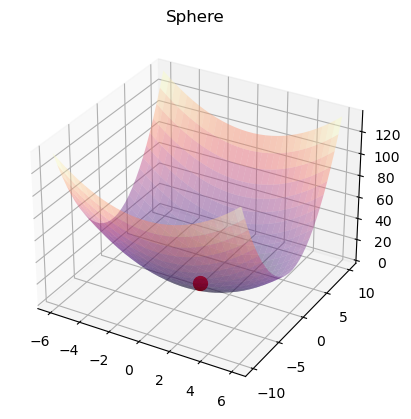

In [23]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[0][1],funcs[0][0])
func = funcs[0][4]
result = SOMA(x,func)
func = funcs[0]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'SphereSOMA.gif')

In [24]:
result

[(1.042891454393767, 0.4186992416035, 1.2629316405668929),
 (0.37173392848908016, 0.17023805623755256, 0.16716710938146467),
 (0.37173214330225796, 0.17023778296222056, 0.16716568911198257),
 (-0.03189735346691284, 0.022684229365215303, 0.0015320154200868727),
 (0.015411525417986259, -0.0009649533097018069, 0.000238446250599141),
 (0.0022473469472620022, -0.0009100724758484401, 5.8788002126647505e-06),
 (0.0008866476000765904, 3.0183280476866808e-05, 7.870549971419226e-07),
 (0.0008862397108952199, 2.9722793976048676e-05, 7.863042696493856e-07),
 (0.0008866461034773962, -9.916011124537684e-06, 7.862396400882715e-07),
 (0.0008862397108952177, 4.0197423223993335e-07, 7.854209867509225e-07),
 (-1.9887393840074385e-05, 4.45142506036937e-08, 3.955104152687354e-10),
 (-1.1579673593291695e-05, 4.402185739919534e-08, 1.3409077845110586e-10),
 (-3.3467853477764567e-06, 4.402606670147082e-08, 1.120291045864038e-11),
 (-2.36834098939101e-06, 4.401455505984884e-08, 5.610976323086706e-12),
 (7.1344

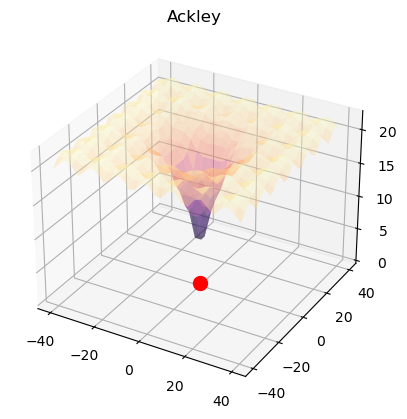

In [25]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[1][1],funcs[1][0])
func = funcs[1][4]
result = SOMA(x,func)
func = funcs[1]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'SOMA.gif')